<a href="https://colab.research.google.com/github/CMC2002/110-2_Project/blob/main/PCAM_with_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorch
!pip install torchvision==0.12.0
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
    Running setup.py install for pytorch ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-f7eu78fu/pytorch_f7f76e6c470c4fc7b0854f3a226e38a9/setup.py'"'"'; __file__='"'"'/tmp/pip-install-f7eu78fu/pytorch_f7f76e6c470c4fc7b0854f3a226e38a9/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-54cb4cpi/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/pytorch Check the logs f

In [3]:
!pip install perlin-noise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!cp -r /content/drive/MyDrive/pcam /content
!mkdir ./model
!cp -r /content/drive/MyDrive/checkpoint.ckpt /content/model
!cp -r /content/drive/MyDrive/output.csv /content/model

In [5]:
!gunzip /content/pcam/camelyonpatch_level_2_split_train_x.h5.gz

In [6]:
!gunzip /content/pcam/camelyonpatch_level_2_split_train_y.h5.gz
!gunzip /content/pcam/camelyonpatch_level_2_split_valid_x.h5.gz
!gunzip /content/pcam/camelyonpatch_level_2_split_valid_y.h5.gz

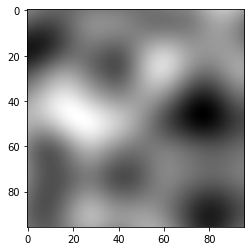

In [7]:
from perlin_noise import PerlinNoise
import matplotlib.pyplot as plt
noise = PerlinNoise(octaves= 3)
mask = [[noise([i*0.01, j*0.01]) for j in range(96)] for i in range(96)]
plt.imshow(mask, cmap= 'gray')
plt.show()

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import scipy
device = "cuda"
mask = torch.Tensor(mask)
trans = transforms.Compose([transforms.RandomVerticalFlip(),
              transforms.RandomHorizontalFlip(),
              transforms.Grayscale(num_output_channels=3),
              transforms.RandomRotation(30, expand=False, center=(48, 48)),
              transforms.ToTensor(),
              transforms.Lambda(lambda img: img+ mask),
              transforms.Normalize(0.5, 1)]) 
trans_v = transforms.Compose([transforms.ToTensor(),
                transforms.Normalize(0.5, 1)])
trainset = torchvision.datasets.PCAM(root="/content", split = 'train', download= True, transform= trans)
validset = torchvision.datasets.PCAM(root="/content", split = 'val', download= True, transform= trans_v)

batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset = trainset, batch_size = batch_size, shuffle = False)
valid_loader = torch.utils.data.DataLoader(dataset = validset, batch_size = batch_size, shuffle = False)

y_valid= []
y_valid_loader = torch.utils.data.DataLoader(dataset = validset, batch_size = 1, shuffle = False)
for data, target in y_valid_loader:
  y_valid.append(target.numpy())

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchsummary import summary
from torchvision import datasets, models, transforms
import torchvision

class resNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.resnet = torchvision.models.resnet34(pretrained = True)
    self.fine_tune = nn.Linear(1000, 2)

  def forward(self, x, fixed=False):
    x = self.resnet(x)
    if fixed:
      x= x.detach()
    x = self.fine_tune(x)
    return x


In [10]:
gmodel = resNet()
gmodel= gmodel.to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = optim.AdamW(gmodel.parameters(), lr = 0.0001)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [11]:
trainaccu = []
validaccu = []
trainloss = []
validloss = []

In [12]:
import numpy as np
import csv
import pandas as pd
Data = pd.read_csv('./model/output.csv', delimiter= ',', encoding= 'utf-8', header= None)
data = Data.to_numpy()
for i in range(0, np.size(data, axis= 1)):
  trainloss.append(data[0][i])
  validloss.append(data[1][i])
for i in range(0, np.size(data, axis= 1)):
  trainaccu.append(data[2][i])
  validaccu.append(data[3][i])


In [13]:
from tqdm import  tqdm
def train(epoch, model):
    if epoch == 0:
      checkpoint=torch.load("./model/checkpoint.ckpt",map_location=device)
      model_state, optimizer_state = checkpoint["model"], checkpoint["optimizer"]
      model.load_state_dict(model_state)
      optimizer.load_state_dict(optimizer_state)
    model.train()
    correct = 0
    train_loss = 0
    # for batch_idx, (data, target) in enumerate(train_loader):
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        # data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_f(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct += (output.argmax(dim=1)==target).sum().item()
    train_loss /= len(train_loader.dataset)
    print('\nTraining  set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    train_loss /= len(train_loader.dataset)
    trainloss.append(train_loss)
    trainaccu.append(correct / len(train_loader.dataset))

In [14]:
valid_output = []
def valid(model):
    model.eval()
    valid_loss = 0
    correct = 0
    loss = []
    global valid_output
    valid_output = []
    for data, target in tqdm(valid_loader):
        # data, target = Variable(data, volatile = True), Variable(target)
        data, target = data.to(device), target.to(device)
        output = model(data)
        valid_output.append(output.detach().cpu().numpy())
        # Sum up vatch loss
        valid_loss += loss_f(output, target).data.item()
        correct += (output.argmax(dim=1)==target).sum().item()
    valid_loss /= len(valid_loader.dataset)
    print('Validation  set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        valid_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))
    validloss.append(valid_loss)
    validaccu.append(correct / len(valid_loader.dataset))
    valid_output = np.concatenate(valid_output)
    return valid_loss

In [21]:
import numpy as np
num_iter= 2
vl = 1
vl2 = 1
for epoch in range(0, num_iter):
    train(epoch, gmodel)
    vl = valid(gmodel)
    if vl > vl2:
      break
    vl2 = vl
torch.save({"model": gmodel.state_dict(), "optimizer": optimizer.state_dict()}, "./model/checkpoint.ckpt")

100%|██████████| 8192/8192 [18:20<00:00,  7.44it/s]



Training  set: Average loss: 0.0038, Accuracy: 249763/262144 (95%)


100%|██████████| 1024/1024 [01:30<00:00, 11.28it/s]


Validation  set: Average loss: 0.0164, Accuracy: 25763/32768 (79%)



100%|██████████| 8192/8192 [17:52<00:00,  7.64it/s]



Training  set: Average loss: 0.0036, Accuracy: 250508/262144 (96%)


100%|██████████| 1024/1024 [01:30<00:00, 11.34it/s]


Validation  set: Average loss: 0.0223, Accuracy: 23841/32768 (73%)



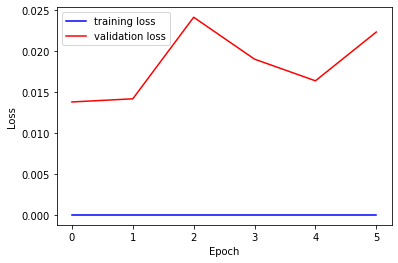

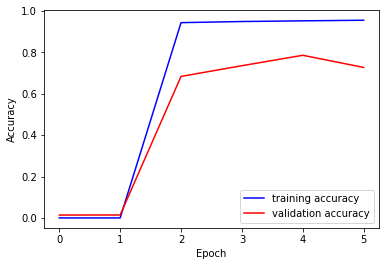

In [22]:
import matplotlib.pyplot as plt
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(0, len(trainloss)), trainloss, color = 'blue', label = 'training loss')
plt.plot(range(0, len(validloss)), validloss, color = 'red', label = 'validation loss')
plt.legend()
plt.show()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(0, len(trainaccu)), trainaccu, color = 'blue', label = 'training accuracy')
plt.plot(range(0, len(validaccu)), validaccu, color = 'red', label = 'validation accuracy')
plt.legend()
plt.show()


In [23]:
import csv
with open('./model/output.csv','w',newline='') as f:
  w = csv.writer(f)
  w.writerow(trainloss)
  w.writerow(validloss)
  w.writerow(trainloss)
  w.writerow(validloss)

In [24]:
valid_result= []
for i in range(0, np.size(valid_output,0)):
  if valid_output[i][0] >= valid_output[i][1]:
    valid_result.append(0)
  else: 
    valid_result.append(1)


AUC=  0.727


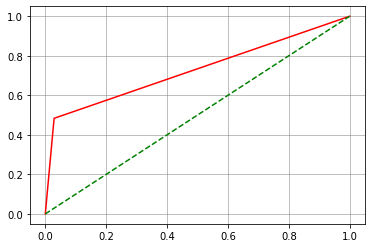

Accuracy=  0.728
Sensitivity=  0.653
Specificity=  0.943
Precision=  0.971
Negative Predictive Value=  0.484


In [25]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
##y_valid= np.array(y_valid, dtype= bool)
##valid_result= np.array(valid_result, dtype= bool)
print("AUC= ", round(roc_auc_score(y_valid, valid_result),3))
fpr, tpr, thresholds = roc_curve(y_valid, valid_result, pos_label= 1)
plt.plot(fpr, tpr, color= 'red', label= 'ROC curve (area = %0.2f)')
plt.grid(color= 'grey', linewidth= 0.5)
plt.plot([0,1], [0,1], color= 'green', linestyle= '--')
plt.show()

from sklearn.metrics import accuracy_score
print("Accuracy= ", round(accuracy_score(valid_result, y_valid), 3))

from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(y_valid, valid_result)
tp = cnf[0][0]
fp = cnf[0][1]
tn = cnf[1][1]
fn = cnf[1][0]
print("Sensitivity= ", round(tp/(tp+fn), 3))
print("Specificity= ", round(tn/(tn+fp), 3))
print("Precision= ", round(tp/(tp+fp), 3))
print("Negative Predictive Value= ", round(tn/(tn+fn), 3))

In [26]:
!cp -r /content/model/checkpoint.ckpt /content/drive/MyDrive
!cp -r /content/model/output.csv /content/drive/MyDrive

In [ ]:
import torch
import torch.nn as nn

from functools import partial
from dataclasses import dataclass
from collections import OrderedDict

class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2)
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)  

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

from collections import OrderedDict

class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

from collections import OrderedDict
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))

class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )

class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
      x = self.gate(x)
      for block in self.blocks:
          x = block(x)
      return x

class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])

def resnet34(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[3, 4, 6, 3])

def resnet50(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 6, 3])

def resnet101(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 23, 3])

def resnet152(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 8, 36, 3])